In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import random
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torchsummary import summary
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

now = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
print("import OK at ", now)
data_path = r"C:\Users\jiant\Desktop\data\shoepad\0817-jt&zy"
class_name = ["backward", "forward", "stand"]

import OK at  2022-09-26 15:29:22


In [2]:
# mock IMU data
import os

files = os.listdir(r"C:\Users\jiant\Desktop\data\shoepad\IMU\backward")


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:\\Users\\jiant\\Desktop\\data\\shoepad\\IMU\\backward'

vis data with random start index (plot can vary each run) =  1772


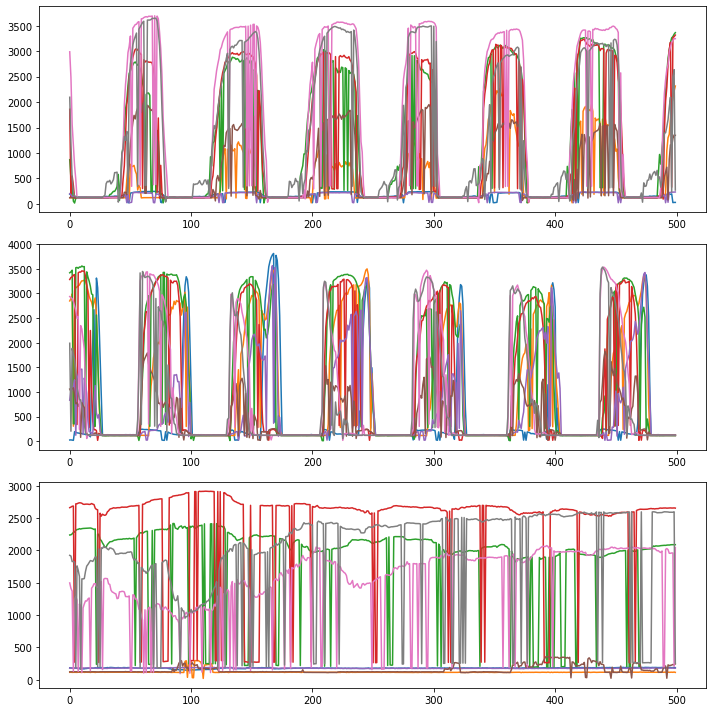

In [22]:
# vis data
sample_data_class_0 = os.listdir(os.path.join(data_path, class_name[0]))[0]
sample_data_class_1 = os.listdir(os.path.join(data_path, class_name[1]))[0]
sample_data_class_2 = os.listdir(os.path.join(data_path, class_name[2]))[0]

plt.rcParams['figure.figsize'] = (10.0, 10.0)  # 单位是inches
fig, axs = plt.subplots(3, 1)

random_start = random.randint(0, 3000)
print("vis data with random start index (plot can vary each run) = ", random_start)

with open(os.path.join(os.path.join(data_path, class_name[0]), sample_data_class_0)) as f:
    logs = f.read().split('\n')
    f1 = [int(i.split(",")[0]) for i in logs if i != '']
    f2 = [int(i.split(",")[1]) for i in logs if i != '']
    f3 = [int(i.split(",")[2]) for i in logs if i != '']
    f4 = [int(i.split(",")[3]) for i in logs if i != '']
    f5 = [int(i.split(",")[4]) for i in logs if i != '']
    f6 = [int(i.split(",")[5]) for i in logs if i != '']
    f7 = [int(i.split(",")[6]) for i in logs if i != '']
    f8 = [int(i.split(",")[7]) for i in logs if i != '']
axs[0].plot(f1[random_start:random_start + 500])
axs[0].plot(f2[random_start:random_start + 500])
axs[0].plot(f3[random_start:random_start + 500])
axs[0].plot(f4[random_start:random_start + 500])
axs[0].plot(f5[random_start:random_start + 500])
axs[0].plot(f6[random_start:random_start + 500])
axs[0].plot(f7[random_start:random_start + 500])
axs[0].plot(f8[random_start:random_start + 500])

with open(os.path.join(os.path.join(data_path, class_name[1]), sample_data_class_1)) as f:
    logs = f.read().split('\n')
    f1 = [int(i.split(",")[0]) for i in logs if i != '']
    f2 = [int(i.split(",")[1]) for i in logs if i != '']
    f3 = [int(i.split(",")[2]) for i in logs if i != '']
    f4 = [int(i.split(",")[3]) for i in logs if i != '']
    f5 = [int(i.split(",")[4]) for i in logs if i != '']
    f6 = [int(i.split(",")[5]) for i in logs if i != '']
    f7 = [int(i.split(",")[6]) for i in logs if i != '']
    f8 = [int(i.split(",")[7]) for i in logs if i != '']
axs[1].plot(f1[random_start:random_start + 500])
axs[1].plot(f2[random_start:random_start + 500])
axs[1].plot(f3[random_start:random_start + 500])
axs[1].plot(f4[random_start:random_start + 500])
axs[1].plot(f5[random_start:random_start + 500])
axs[1].plot(f6[random_start:random_start + 500])
axs[1].plot(f7[random_start:random_start + 500])
axs[1].plot(f8[random_start:random_start + 500])

with open(os.path.join(os.path.join(data_path, class_name[2]), sample_data_class_2)) as f:
    logs = f.read().split('\n')
    f1 = [int(i.split(",")[0]) for i in logs if i != '']
    f2 = [int(i.split(",")[1]) for i in logs if i != '']
    f3 = [int(i.split(",")[2]) for i in logs if i != '']
    f4 = [int(i.split(",")[3]) for i in logs if i != '']
    f5 = [int(i.split(",")[4]) for i in logs if i != '']
    f6 = [int(i.split(",")[5]) for i in logs if i != '']
    f7 = [int(i.split(",")[6]) for i in logs if i != '']
    f8 = [int(i.split(",")[7]) for i in logs if i != '']
axs[2].plot(f1[random_start:random_start + 500])
axs[2].plot(f2[random_start:random_start + 500])
axs[2].plot(f3[random_start:random_start + 500])
axs[2].plot(f4[random_start:random_start + 500])
axs[2].plot(f5[random_start:random_start + 500])
axs[2].plot(f6[random_start:random_start + 500])
axs[2].plot(f7[random_start:random_start + 500])
axs[2].plot(f8[random_start:random_start + 500])

fig.tight_layout()
# plt.show()

In [23]:
# build dataset
# 思路 :
# 观察到一次踏步触地的时间基本在 100 个数据点以内,故取 50 为数据长度，50HZ==>1秒
# 在一次数据起点内，随机起点 5 次，固定间隔采样 获得数据

data_length = 50  # AD数据长度。 data_length=100 & fps=50 意味着每两秒sample一次数据
sample_num = 5  # 每次数据随机采样次数
sample_gap = int(data_length / sample_num)
start_lag = random.randint(0, sample_gap)
start_indexes = [start_lag + sample_gap * i for i in range(sample_num)]
print(f"随机的{sample_num}次起点是{start_indexes}")

随机的5次起点是[10, 20, 30, 40, 50]


In [24]:
data_class_0 = []
files_data_class_0 = os.listdir(os.path.join(data_path, class_name[0]))
count = 0
time2_start = -1
for file in files_data_class_0:
    with open(os.path.join(os.path.join(data_path, class_name[0]), file)) as f:
        logs = f.read().split('\n')
        f1 = [int(i.split(",")[0]) for i in logs if i != '']
        f2 = [int(i.split(",")[1]) for i in logs if i != '']
        f3 = [int(i.split(",")[2]) for i in logs if i != '']
        f4 = [int(i.split(",")[3]) for i in logs if i != '']
        f5 = [int(i.split(",")[4]) for i in logs if i != '']
        f6 = [int(i.split(",")[5]) for i in logs if i != '']
        f7 = [int(i.split(",")[6]) for i in logs if i != '']
        f8 = [int(i.split(",")[7]) for i in logs if i != '']
    i_data_class_0 = np.vstack([f1, f2, f3, f4, f5, f6, f7, f8])  # shape = 8*N
    print("loading file :", file)
    # print(i_data_class_0)
    # print(i_data_class_0.shape)
    # print(i_data_class_0.shape[1])
    i_max_loop = i_data_class_0.shape[1] // data_length
    for j in range(sample_num):
        for i in range(i_max_loop):
            if (i * data_length + start_indexes[j] + data_length) < i_data_class_0.shape[1]:
                # print(f"append with {i * data_length + start_indexes[j]} to {i * data_length + start_indexes[j] + data_length}")
                count += 1
                if j == 1 and time2_start < 0:
                    time2_start = count
                data_class_0.append(i_data_class_0[:,
                                    i * data_length + start_indexes[j]:i * data_length + start_indexes[j] + data_length])

print("............检查数据准确性............")
print(f"理论构建的classes 的数据总量 约等于 txt文件数*sample_num*每个文件行数/data_length")
print(f"实际构建的classes 的数据总量 = {len(data_class_0)},")
print(f"随机的{sample_num}次起点是{start_indexes}")
print(f"以下是第1个数据，理论shape=8*{data_length},对应txt的起点=第{start_indexes[0] + 1}行,请核对txt检查")
print(data_class_0[0])
print(f"以下是第2个数据，理论shape=8*{data_length},对应txt的起点=第{start_indexes[0] + data_length + 1}行,请核对txt检查")
print(data_class_0[1])
print(f"以下是第{time2_start}个数据，理论shape=8*{data_length},对应txt的起点=第{start_indexes[1] + 1}行,请核对txt检查")
print(data_class_0[time2_start - 1])

loading file : left_data_backward_01.txt
loading file : left_data_backward_02.txt
loading file : left_data_backward_03.txt
loading file : left_data_backward_04.txt
loading file : left_data_backward_05.txt
loading file : left_data_backward_06.txt
loading file : left_data_backward_07.txt
loading file : left_data_backward_08.txt
loading file : left_data_backward_09.txt
loading file : left_data_backward_10.txt
loading file : left_data_backward_t01.txt
loading file : left_data_backward_t02.txt
............检查数据准确性............
理论构建的classes 的数据总量 约等于 txt文件数*sample_num*每个文件行数/data_length
实际构建的classes 的数据总量 = 5781,
随机的5次起点是[10, 20, 30, 40, 50]
以下是第1个数据，理论shape=8*50,对应txt的起点=第11行,请核对txt检查
[[ 154  151  150  134  128  129  127  129  129  128  129  130  130  131
   132  132  132  132  139  139  143  140  140  146  145  147  148  145
   147  147  148  148  143  143  148  145  144  143  144  146  145  145
   153  161  166  173  176  182  189  192]
 [ 119  118  116   15  360  725  826  868 1067  111 13

In [25]:
data_class_1 = []
files_data_class_1 = os.listdir(os.path.join(data_path, class_name[1]))
count = 0
time2_start = -1
for file in files_data_class_1:
    with open(os.path.join(os.path.join(data_path, class_name[1]), file)) as f:
        logs = f.read().split('\n')
        f1 = [int(i.split(",")[0]) for i in logs if i != '']
        f2 = [int(i.split(",")[1]) for i in logs if i != '']
        f3 = [int(i.split(",")[2]) for i in logs if i != '']
        f4 = [int(i.split(",")[3]) for i in logs if i != '']
        f5 = [int(i.split(",")[4]) for i in logs if i != '']
        f6 = [int(i.split(",")[5]) for i in logs if i != '']
        f7 = [int(i.split(",")[6]) for i in logs if i != '']
        f8 = [int(i.split(",")[7]) for i in logs if i != '']
    i_data_class_0 = np.vstack([f1, f2, f3, f4, f5, f6, f7, f8])  # shape = 8*N
    print("loading file :", file)
    # print(i_data_class_0)
    # print(i_data_class_0.shape)
    # print(i_data_class_0.shape[1])
    i_max_loop = i_data_class_0.shape[1] // data_length
    for j in range(sample_num):
        for i in range(i_max_loop):
            if (i * data_length + start_indexes[j] + data_length) < i_data_class_0.shape[1]:
                # print(f"append with {i * data_length + start_indexes[j]} to {i * data_length + start_indexes[j] + data_length}")
                count += 1
                if j == 1 and time2_start < 0:
                    time2_start = count
                data_class_1.append(i_data_class_0[:,
                                    i * data_length + start_indexes[j]:i * data_length + start_indexes[j] + data_length])
print("............检查数据准确性............")
print(f"理论构建的classes 的数据总量 约等于 txt文件数*sample_num*每个文件行数/data_length")
print(f"实际构建的classes 的数据总量 = {len(data_class_1)},")
print(f"随机的{sample_num}次起点是{start_indexes}")
print(f"以下是第1个数据，理论shape=8*{data_length},对应txt的起点=第{start_indexes[0] + 1}行,请核对txt检查")
print(data_class_1[0])
print(f"以下是第2个数据，理论shape=8*{data_length},对应txt的起点=第{start_indexes[0] + data_length + 1}行,请核对txt检查")
print(data_class_1[1])
print(f"以下是第{time2_start}个数据，理论shape=8*{data_length},对应txt的起点=第{start_indexes[1] + 1}行,请核对txt检查")
print(data_class_1[time2_start - 1])


loading file : left_data_forward_01.txt
loading file : left_data_forward_02.txt
loading file : left_data_forward_03.txt
loading file : left_data_forward_04.txt
loading file : left_data_forward_05.txt
loading file : left_data_forward_t01.txt
loading file : left_data_forward_t02.txt
loading file : left_data_forward_t03.txt
............检查数据准确性............
理论构建的classes 的数据总量 约等于 txt文件数*sample_num*每个文件行数/data_length
实际构建的classes 的数据总量 = 3789,
随机的5次起点是[10, 20, 30, 40, 50]
以下是第1个数据，理论shape=8*50,对应txt的起点=第11行,请核对txt检查
[[ 131  131  130  132  130  132  133  132  131  130  131  132  130  130
   131  131  132  129  132  131  134  196  232  240  240  241  239  240
   240  241  242  243  241  242  242  241  239  236  230  225  225  222
   218  217  214  211  197  192  195  177]
 [ 125  125  123  124  125  123  124  124  122  126  123  124  125  124
   124  124  126  124  124  121  120  120  119  121  122  120  119  120
   121  120  118  120  119  117   29  544  743 1033 1367 1458 1472 1451
  1728 19

In [26]:
data_class_2 = []
files_data_class_2 = os.listdir(os.path.join(data_path, class_name[2]))
count = 0
time2_start = -1
for file in files_data_class_2:
    with open(os.path.join(os.path.join(data_path, class_name[2]), file)) as f:
        logs = f.read().split('\n')
        f1 = [int(i.split(",")[0]) for i in logs if i != '']
        f2 = [int(i.split(",")[1]) for i in logs if i != '']
        f3 = [int(i.split(",")[2]) for i in logs if i != '']
        f4 = [int(i.split(",")[3]) for i in logs if i != '']
        f5 = [int(i.split(",")[4]) for i in logs if i != '']
        f6 = [int(i.split(",")[5]) for i in logs if i != '']
        f7 = [int(i.split(",")[6]) for i in logs if i != '']
        f8 = [int(i.split(",")[7]) for i in logs if i != '']
    i_data_class_0 = np.vstack([f1, f2, f3, f4, f5, f6, f7, f8])  # shape = 8*N
    print("loading file :", file)
    # print(i_data_class_0)
    # print(i_data_class_0.shape)
    # print(i_data_class_0.shape[1])
    i_max_loop = i_data_class_0.shape[1] // data_length
    for j in range(sample_num):
        for i in range(i_max_loop):
            if (i * data_length + start_indexes[j] + data_length) < i_data_class_0.shape[1]:
                # print(f"append with {i * data_length + start_indexes[j]} to {i * data_length + start_indexes[j] + data_length}")
                count += 1
                if j == 1 and time2_start < 0:
                    time2_start = count
                data_class_2.append(i_data_class_0[:,
                                    i * data_length + start_indexes[j]:i * data_length + start_indexes[j] + data_length])
print("............检查数据准确性............")
print(f"理论构建的classes 的数据总量 约等于 txt文件数*sample_num*每个文件行数/data_length")
print(f"实际构建的classes 的数据总量 = {len(data_class_2)},")
print(f"随机的{sample_num}次起点是{start_indexes}")
print(f"以下是第1个数据，理论shape=8*{data_length},对应txt的起点=第{start_indexes[0] + 1}行,请核对txt检查")
print(data_class_2[0])
print(f"以下是第2个数据，理论shape=8*{data_length},对应txt的起点=第{start_indexes[0] + data_length + 1}行,请核对txt检查")
print(data_class_2[1])
print(f"以下是第{time2_start}个数据，理论shape=8*{data_length},对应txt的起点=第{start_indexes[1] + 1}行,请核对txt检查")
print(data_class_2[time2_start - 1])

loading file : left_data_stand_01.txt
loading file : left_data_stand_02.txt
loading file : left_data_stand_03.txt
loading file : left_data_stand_04.txt
loading file : left_data_stand_05.txt
loading file : left_data_stand_06.txt
loading file : left_data_stand_07.txt
loading file : left_data_stand_t01.txt
loading file : left_data_stand_t02.txt
............检查数据准确性............
理论构建的classes 的数据总量 约等于 txt文件数*sample_num*每个文件行数/data_length
实际构建的classes 的数据总量 = 4058,
随机的5次起点是[10, 20, 30, 40, 50]
以下是第1个数据，理论shape=8*50,对应txt的起点=第11行,请核对txt检查
[[ 183  183  185  184  183  182  180  183  179  173  165  156  156  146
   147  146  149  150  159  165  169  164  164  162  154  153  148  157
   153  151  145  142  139  136  134  137  140  135  137  136  138  137
   136  138  138  139  132  133  133  130]
 [ 115  114  115  116  117  117  116  115  117  116  115  113  114  116
   115  115  115  116  114  115  115  113  117  115  117  114  115  116
   116  114  114  115  114  117  116  115  116  116  116  11

In [27]:
label_class_0 = [class_name[0] for i in range(len(data_class_0))]  # class name
label_class_1 = [class_name[1] for i in range(len(data_class_1))]
label_class_2 = [class_name[2] for i in range(len(data_class_2))]
all_data = data_class_0 + data_class_1 + data_class_2
all_label = label_class_0 + label_class_1 + label_class_2
if not len(all_data) == len(all_label):
    raise RuntimeError
print(f"dataset 组合完毕,总数据量为{len(all_data)}")
print(f"dataset 一个例子:shape of model input data (without extend & the batch dim) is {all_data[0].shape}")
print(f",三个类别的数据量分别为{len(data_class_0)},{len(data_class_1)},{len(data_class_2)}")


dataset 组合完毕,总数据量为13628
dataset 一个例子:shape of model input data (without extend & the batch dim) is (8, 50)
,三个类别的数据量分别为5781,3789,4058


In [28]:
def random_true(prob):
    p = ([prob, 1 - prob])
    return np.random.choice([True, False], p=p)


class CustomDataset(Dataset):
    def __init__(self, images_, labels_, transform=None):
        self.images = images_
        self.labels = labels_
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx]).type(torch.long)
        return img, label  # img / label shall be tensor or numpy


data_train = []
label_train = []
data_val = []
label_val = []
data_test = []
label_test = []
for i in range(len(all_label)):
    if random_true(0.6):
        data_train.append(all_data[i])
        label_train.append(all_label[i])
    else:
        if random_true(0.5):
            data_val.append(all_data[i])
            label_val.append(all_label[i])
        else:
            data_test.append(all_data[i])
            label_test.append(all_label[i])

# label transfer 2 int
label_train = [class_name.index(i) for i in label_train]
label_val = [class_name.index(i) for i in label_val]
label_test = [class_name.index(i) for i in label_test]

# 8*10 ==> 1*8*10
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.ToTensor()
])

print(f"tran val text split finished with length = {len(data_train)},{len(data_val)},{len(data_test)}")

train = CustomDataset(data_train, label_train, train_transform)
val = CustomDataset(data_val, label_val, test_transform)
test = CustomDataset(data_test, label_test, test_transform)

test_bs = 16
train_loader = DataLoader(train, batch_size=test_bs, shuffle=True)
val_loader = DataLoader(val, batch_size=test_bs, shuffle=True)
test_loader = DataLoader(test, batch_size=test_bs, shuffle=True)
print('========reading all img into memory done! ready to --fly--')

for j, (_inputs, _labels) in enumerate(train_loader):
    print(f"checking {j}th data")
    print(_labels.shape)
    print(_inputs.shape)
    print(_labels)
    print(_inputs)
    if j == 5:
        break

tran val text split finished with length = 8165,2751,2712
========reading all img into memory done! ready to --fly--
checking 0th data
torch.Size([16])
torch.Size([16, 1, 8, 50])
tensor([0, 1, 1, 2, 0, 1, 0, 2, 0, 2, 1, 0, 1, 0, 1, 0])
tensor([[[[ 151,  141,  130,  ...,  222,  224,  226],
          [ 134,  133,  132,  ...,  129,  130,  130],
          [ 392,   19,  115,  ..., 1146, 1170, 1159],
          ...,
          [ 158,  136,  131,  ...,  610,  452,  590],
          [ 121,  694,  373,  ..., 2536, 2547, 2584],
          [ 655,  418,  136,  ..., 3353, 3375, 3387]]],


        [[[ 130,  131,  132,  ..., 3635, 3034, 2661],
          [ 132,  133,  131,  ..., 2463,   29,  217],
          [ 711,  731,  793,  ...,  147,  617,  521],
          ...,
          [ 123,  124,  124,  ...,  257,  195,  216],
          [ 121,  122,  123,  ...,  121,  123,  123],
          [ 126,  126,  126,  ...,  126,  124,  124]]],


        [[[ 131,  132,  131,  ...,  157,  161,  156],
          [ 129,  127,  

In [29]:
class V1_Backbone(nn.Module):
    def __init__(self):
        super(V1_Backbone, self).__init__()

        self.first_layers = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=(1, 5), stride=1, padding="valid"),
            # nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.Conv2d(50, 50, (1, 3), 1, padding="same"),
            # nn.BatchNorm2d(50),
            nn.ReLU(),

            # nn.Linear(4608, 50),
            nn.MaxPool2d(1, 2),
            nn.Dropout(p=0.2),

            nn.Conv2d(50, 40, (1, 5), stride=1, padding="valid"),
            nn.ReLU(),
            # nn.BatchNorm2d(40),
            # nn.Linear(4608, 50),
            nn.MaxPool2d(1, 2),
            nn.Dropout(p=0.2),

            nn.Conv2d(40, 20, (1, 3), stride=1, padding="valid"),
            # nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

        self.sec_layers = nn.Sequential(
            nn.Linear(320, 200),
            nn.Dropout(p=0.4),
        )

    def forward(self, input):
        x = self.first_layers(input)
        x = x.view(x.size()[0], -1)
        x = self.sec_layers(x)
        return x


class V1_Net(V1_Backbone):
    def __init__(self):
        super().__init__()
        self.lin3 = nn.Linear(200, 3)

    def forward(self, inp):
        x = super().forward(inp)
        x = self.lin3(x)
        return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("summary of network...")
# params最后print出来要除以100万转换为M为单位（论文中常用的格式）
_net = V1_Net().to(device)
summary(_net, (1, 8, 50))

summary of network...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 50, 8, 46]             300
              ReLU-2            [-1, 50, 8, 46]               0
            Conv2d-3            [-1, 50, 8, 46]           7,550
              ReLU-4            [-1, 50, 8, 46]               0
         MaxPool2d-5            [-1, 50, 4, 23]               0
           Dropout-6            [-1, 50, 4, 23]               0
            Conv2d-7            [-1, 40, 4, 19]          10,040
              ReLU-8            [-1, 40, 4, 19]               0
         MaxPool2d-9            [-1, 40, 2, 10]               0
          Dropout-10            [-1, 40, 2, 10]               0
           Conv2d-11             [-1, 20, 2, 8]           2,420
             ReLU-12             [-1, 20, 2, 8]               0
          Dropout-13             [-1, 20, 2, 8]               0
           Linear

In [30]:
def train_CV(net, dataloader, criterion, optimizer, scaler, e):
    net = net.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0

    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        # calculate performance metrics
        loss_tr += loss.item()
        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples
    #print(f"loss on train set at epoch {e} is {loss}")
    print(f"==>acc on train set at epoch {e} is {round(acc, 5)} %")
    return acc, loss


def val_CV(net, dataloader, criterion, e):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_tr += loss.item()
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples
    #print(f"loss on val set at epoch {e} is {loss}")
    print(f"====>acc on val set at epoch {e} is {round(acc, 5)} %")
    return acc, loss, e


def test_CV(net, dataloader, e):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)
            outputs = net(inputs)
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n_samples += labels.size(0)
    acc = 100 * correct_count / n_samples
    print(f"=========>acc on test set at epoch {e} is {round(acc, 5)} %")
    return acc


def save(net, path):
    checkpoint = {
        'params': net.state_dict()
    }
    # save checkpoint
    torch.save(checkpoint, path)


def start_train():
    model = V1_Net
    net = model().to(device)
    scaler = GradScaler()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.0001)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
    criterion = nn.CrossEntropyLoss()

    print('============================ training start ==================================')
    max_epoch = 400
    save_freq = 500  # if >max_epoch不会存 checkpoint

    best_acc = 0.0
    for epoch in range(max_epoch):
        _acc_tr, _loss_tr = train_CV(net, train_loader, criterion, optimizer, scaler, epoch)
        _acc_v, _loss_v, _ = val_CV(net, val_loader, criterion, epoch)
        scheduler.step(_acc_v)
        # save when _acc_v is better
        if _acc_v > best_acc and epoch >= 80:  # 节约时间,前几轮不存
            _acc_t = test_CV(net, val_loader, epoch)
            print(f'a better val acc found, so save check point, epoch is {epoch}')
            best_acc = _acc_v
            pkl_name = str(epoch) + "_best.pkl"
            path = os.path.join(r'../materials', pkl_name)
            torch.save(net, path)
        # save when at point
        if (epoch + 1) % save_freq == 0:
            print(f'just save check point at epoch {epoch}')
            pkl_name = str(epoch) + ".pkl"
            path = os.path.join(r'../materials', pkl_name)
            torch.save(net, path)


start_train()

============================ training start ==================================
==>acc on train set at epoch 0 is 41.92284 %
====>acc on val set at epoch 0 is 42.09378 %
==>acc on train set at epoch 1 is 42.43723 %
====>acc on val set at epoch 1 is 42.09378 %
==>acc on train set at epoch 2 is 47.61788 %
====>acc on val set at epoch 2 is 53.10796 %
==>acc on train set at epoch 3 is 52.85977 %
====>acc on val set at epoch 3 is 56.2341 %
==>acc on train set at epoch 4 is 56.43601 %
====>acc on val set at epoch 4 is 58.96038 %
==>acc on train set at epoch 5 is 59.63258 %
====>acc on val set at epoch 5 is 65.3944 %
==>acc on train set at epoch 6 is 62.06981 %
====>acc on val set at epoch 6 is 63.90403 %
==>acc on train set at epoch 7 is 65.60931 %
====>acc on val set at epoch 7 is 65.6125 %
==>acc on train set at epoch 8 is 65.80527 %
====>acc on val set at epoch 8 is 59.43293 %
==>acc on train set at epoch 9 is 70.11635 %
====>acc on val set at epoch 9 is 74.08215 %
==>acc on train set at e